In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

### Loading the Data

In [4]:
# Loading the saved pca features
pca = np.load("pca.npy")
labels = np.load("Labels.npy")

hog_features = np.load("hogfeatures.npy")
data = np.concatenate((pca, hog_features),axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
X_train.shape

(5618, 1191)

### Random Forest Classifier

In [6]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train.flatten())
print(f"Training accuracy using random forest -> {accuracy_score(y_train, rfc.predict(X_train))} ")
print(f"Test accuracy using random forest -> {accuracy_score(y_test, rfc.predict(X_test))} ")
print(classification_report(y_test, rfc.predict(X_test)))

Training accuracy using random forest -> 1.0 
Test accuracy using random forest -> 0.9309608540925267 
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       401
         1.0       0.96      0.83      0.89       317
         2.0       0.87      0.92      0.89       322
         3.0       0.91      0.98      0.94       365

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405



### SVM

Training accuracy using SVM -> 1.0 
Test accuracy using SVM -> 0.9672597864768683 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       401
         1.0       0.96      0.94      0.95       317
         2.0       0.93      0.95      0.94       322
         3.0       0.99      0.99      0.99       365

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405



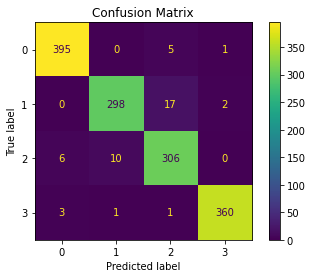

In [7]:
svc = make_pipeline(StandardScaler(), SVC(C=5,gamma='auto', max_iter=-1))
svc.fit(X_train, y_train.flatten())
print(f"Training accuracy using SVM -> {accuracy_score(y_train, svc.predict(X_train))} ")
print(f"Test accuracy using SVM -> {accuracy_score(y_test, svc.predict(X_test))} ")
print(classification_report(y_test, svc.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, svc.predict(X_test)))
disp.plot()
plt.title("Confusion Matrix")
plt.show()

### Neural Network

In [8]:
def neural_network_v2(input_shape):
    initializer = tf.keras.initializers.HeNormal()
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tfl.Dense(32, activation='relu', kernel_initializer=initializer)(inputs)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.4)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu', kernel_initializer=initializer)(x)    
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(1028, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.4)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

nn = neural_network_v2(X_train.shape[1])
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy())

epochs = 100
batch_size = 32

history = nn.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose = 1, validation_data=(X_test, y_test))

Epoch 1/100
176/176 [==============================] - 6s 16ms/step - loss: 1.5377 - accuracy: 0.3300 - val_loss: 1.1723 - val_accuracy: 0.4982
Epoch 2/100
176/176 [==============================] - 3s 15ms/step - loss: 1.2269 - accuracy: 0.4448 - val_loss: 1.2709 - val_accuracy: 0.4726
Epoch 3/100
176/176 [==============================] - 3s 15ms/step - loss: 1.0014 - accuracy: 0.5808 - val_loss: 1.1216 - val_accuracy: 0.5715
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.8407 - accuracy: 0.6552 - val_loss: 1.0952 - val_accuracy: 0.5943
Epoch 5/100
176/176 [==============================] - 3s 15ms/step - loss: 0.7338 - accuracy: 0.6935 - val_loss: 0.8992 - val_accuracy: 0.6413
Epoch 6/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6566 - accuracy: 0.7289 - val_loss: 0.7958 - val_accuracy: 0.6733
Epoch 7/100
176/176 [==============================] - 3s 17ms/step - loss: 0.6089 - accuracy: 0.7460 - val_loss: 0.7353 - val_accuracy:

In [9]:
acc = nn.evaluate(X_test, y_test, verbose = 1)
print(f"Best accuracy achieved = {acc[1]*100}")
print( np.argmax(nn.predict(X_test, batch_size = 1), axis = 1))
print(classification_report(y_test, np.argmax(nn.predict(X_test, batch_size = 1), axis = 1)))

44/44 [==============================] - 0s 5ms/step - loss: 0.3700 - accuracy: 0.9310
Best accuracy achieved = 93.09608340263367
[1 0 0 ... 2 1 3]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       401
         1.0       0.85      0.94      0.89       317
         2.0       0.92      0.83      0.87       322
         3.0       0.95      0.98      0.96       365

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405



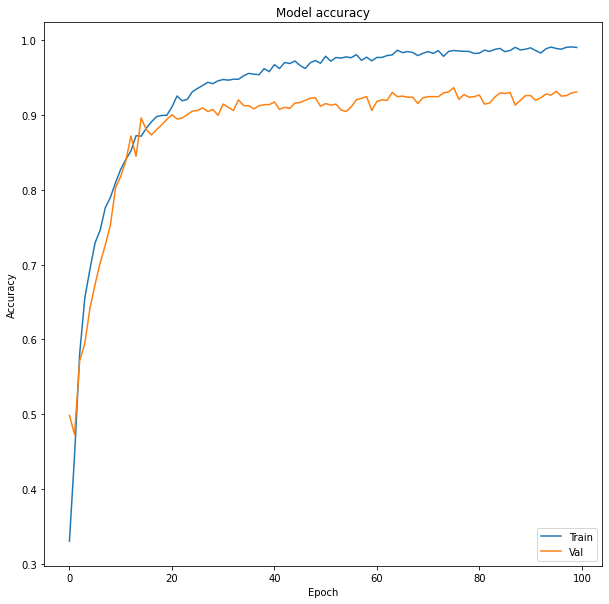

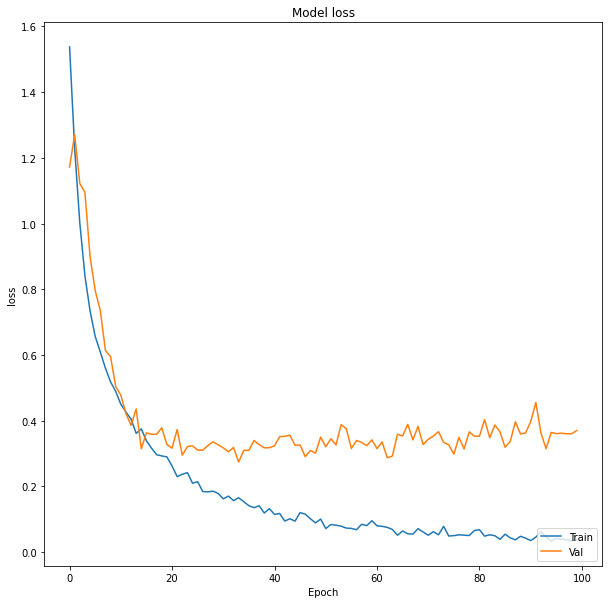

In [10]:
plt.figure(figsize =(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.figure(figsize =(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.show()